In [188]:
import pandas as pd
from pandas import ExcelWriter, ExcelFile
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import AgglomerativeClustering

import scipy.cluster.hierarchy as shc

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from random import sample
from numpy.random import uniform
from math import isnan

from yellowbrick.cluster import KElbowVisualizer

In [189]:
# TODO: sheet_name change
original_df= pd.read_excel('newdata.xlsx', sheet_name='TAXONOMY DATA')

/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [190]:
datasize = 72
df = original_df.iloc[1:]
df.columns = df.iloc[0]
df = df.drop(df.index[0])
df = df.iloc[:datasize]
df = df.iloc[:, 2:22]

In [191]:
X = df.copy()
from sklearn.preprocessing import LabelEncoder

X.iloc[:]=X.iloc[:].apply(LabelEncoder().fit_transform)

In [192]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(df).toarray())

In [193]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def delta(c1, c2):
    values = np.ones([len(c1), len(c2)])*10000
    
    for i in range(0, len(c1)):
        for j in range(0, len(c2)):
            values[i, j] = np.linalg.norm(c1[i]-c2[j])
            
    return np.min(values)
    
def big_delta(ci):
    values = np.zeros([len(ci), len(ci)])
    
    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])
            
    return np.max(values)
    
def dunn(k_list):
    deltas = np.ones([len(k_list), len(k_list)])*1000000
    big_deltas = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta(k_list[k], k_list[l])
        
        big_deltas[k] = big_delta(k_list[k])

    di = np.min(deltas)/np.max(big_deltas)
    return di

def delta_fast(c1, c2, distances):
    values = distances[np.where(c1)][:, np.where(c2)]
    values = values[np.nonzero(values)]

    return np.min(values)
    
def big_delta_fast(ci, distances):
    values = distances[np.where(ci)][:, np.where(ci)]
    #values = values[np.nonzero(values)]
            
    return np.max(values)

def dunn_fast(points, labels):
    distances = euclidean_distances(points)
    ks = np.sort(np.unique(labels))
    
    deltas = np.ones([len(ks), len(ks)])*1000000
    big_deltas = np.zeros([len(ks), 1])
    
    l_range = list(range(0, len(ks)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta_fast((labels == ks[k]), (labels == ks[l]), distances)
        
        big_deltas[k] = big_delta_fast((labels == ks[k]), distances)

    di = np.min(deltas)/np.max(big_deltas)
    return di
    
    
def  big_s(x, center):
    len_x = len(x)
    total = 0
        
    for i in range(len_x):
        total += np.linalg.norm(x[i]-center)    
    
    return total/len_x

def davisbouldin(k_list, k_centers):
    len_k_list = len(k_list)
    big_ss = np.zeros([len_k_list], dtype=np.float64)
    d_eucs = np.zeros([len_k_list, len_k_list], dtype=np.float64)
    db = 0    

    for k in range(len_k_list):
        big_ss[k] = big_s(k_list[k], k_centers[k])

    for k in range(len_k_list):
        for l in range(0, len_k_list):
            d_eucs[k, l] = np.linalg.norm(k_centers[k]-k_centers[l])

    for k in range(len_k_list):
        values = np.zeros([len_k_list-1], dtype=np.float64)
        for l in range(0, k):
            values[l] = (big_ss[k] + big_ss[l])/d_eucs[k, l]
        for l in range(k+1, len_k_list):
            values[l-1] = (big_ss[k] + big_ss[l])/d_eucs[k, l]

        db += np.max(values)
    res = db/len_k_list
    return 

In [194]:
cluster_size = 2
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)

In [195]:
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)

In [196]:
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

In [197]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()

In [198]:
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
 
k_list = [clus0.values, clus1.values]
k_Cluster_2 = dunn(k_list)

In [199]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()

In [200]:
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
 
a_list = [clus0.values, clus1.values]
a_Cluster_2 = dunn(a_list)

In [201]:
print(k_Cluster_2,a_Cluster_2)

0.25870933248520733 0.2966534000883905


In [202]:
cluster_size = 3
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)

In [203]:
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)

In [204]:
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

In [205]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()

In [206]:
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]

k_list = [clus0.values, clus1.values, clus2.values]
k_Cluster_3 = dunn(k_list)

In [207]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()

In [208]:
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]

a_list = [clus0.values, clus1.values, clus2.values]
a_Cluster_3 = dunn(a_list)

In [209]:
print(k_Cluster_3,a_Cluster_3)

0.26813039720295667 0.3149556431496282


In [210]:
cluster_size = 4
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)

In [211]:
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

In [212]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()

In [213]:
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
 
k_list = [clus0.values, clus1.values,clus2.values,clus3.values]
k_Cluster_4 = dunn(k_list)

In [214]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()

In [215]:
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  

a_list = [clus0.values, clus1.values,clus2.values,clus3.values]
a_Cluster_4 = dunn(a_list)

In [216]:
print(k_Cluster_4,a_Cluster_4)

0.3179503147537684 0.33911537590743585


In [217]:
cluster_size = 5
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)

In [218]:
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)

In [219]:
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

In [220]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()

In [221]:
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values]
k_Cluster_5 = dunn(k_list)

In [222]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()

In [223]:
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values]
a_Cluster_5 = dunn(a_list)

In [224]:
print(k_Cluster_5,a_Cluster_5)

0.3187042369409263 0.3494681278325547


In [225]:
cluster_size = 6
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)

In [226]:
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

In [227]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()

In [228]:
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5] 
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values]
k_Cluster_6 = dunn(k_list)

In [229]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()

In [230]:
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5] 
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values]
a_Cluster_6 = dunn(a_list)

In [231]:
print(k_Cluster_6,a_Cluster_6)

0.36666261242967924 0.3748277894093769


In [232]:
cluster_size = 7
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)

In [233]:
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

In [234]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()

In [235]:
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values]
k_Cluster_7 = dunn(k_list)

In [236]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()

In [237]:
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5] 
clus6 = prediction.loc[prediction.pred == 6]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values]
a_Cluster_7 = dunn(a_list)

In [238]:
print(k_Cluster_7,a_Cluster_7)

0.34676008218645943 0.3748277894093769


In [239]:
cluster_size = 8
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)

In [240]:
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

In [241]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()

In [242]:
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values]
k_Cluster_8 = dunn(k_list)

In [243]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()

In [244]:
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5] 
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values]
a_Cluster_8 = dunn(a_list)

In [245]:
print(k_Cluster_8,a_Cluster_8)

0.4118771037102598 0.42133522682169783


In [246]:
cluster_size = 9
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)

In [247]:
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

In [248]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()

In [249]:
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values]
k_Cluster_9 = dunn(k_list)

In [250]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()

In [251]:
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5] 
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values]
a_Cluster_9 = dunn(a_list)

In [252]:
print(k_Cluster_9,a_Cluster_9)

0.3848109220835296 0.36753532257156196


In [253]:
cluster_size = 10
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values]
k_Cluster_10 = dunn(k_list)

In [254]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5] 
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values]
a_Cluster_10 = dunn(a_list)
print(k_Cluster_10,a_Cluster_10)

0.4262891335333421 0.38152050003002946


In [255]:
cluster_size = 11
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values]
k_Cluster_11 = dunn(k_list)

In [256]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values]
a_Cluster_11 = dunn(a_list)
print(k_Cluster_11,a_Cluster_11)

0.5507406744914735 0.588347090646328


In [257]:
cluster_size = 12
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values]
k_Cluster_12 = dunn(k_list)

In [258]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values]
a_Cluster_12 = dunn(a_list)
print(k_Cluster_12,a_Cluster_12)

0.4670310122352045 0.6373241367818012


In [259]:
cluster_size = 13
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values]
k_Cluster_13 = dunn(k_list)

In [260]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values]
a_Cluster_13 = dunn(a_list)
print(k_Cluster_13,a_Cluster_13)

0.5676884687170396 0.5086492419031837


In [261]:
cluster_size = 14
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values]
k_Cluster_14 = dunn(k_list)

In [262]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values]
a_Cluster_14 = dunn(a_list)
print(k_Cluster_14,a_Cluster_14)

0.4013618337830379 0.5086492419031837


In [263]:
cluster_size = 15
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values]
k_Cluster_15 = dunn(k_list)

In [264]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values]
a_Cluster_15 = dunn(a_list)
print(k_Cluster_15,a_Cluster_15)

0.45173572941404283 0.5728003251811395


In [265]:
cluster_size = 16
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values]
k_Cluster_16 = dunn(k_list)

In [266]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values]
a_Cluster_16 = dunn(a_list)
print(k_Cluster_16,a_Cluster_16)

0.5758664339209429 0.5118775498860251


In [267]:
cluster_size = 17
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values]
k_Cluster_17 = dunn(k_list)

In [268]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values]
a_Cluster_17 = dunn(a_list)
print(k_Cluster_17,a_Cluster_17)

0.61590110993894 0.5742041914390388


In [269]:
cluster_size = 18
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
clus17 = prediction.loc[prediction.pred == 17]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values
         ,clus17.values]
k_Cluster_18 = dunn(k_list)

In [270]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
clus17 = prediction.loc[prediction.pred == 17]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values
         ,clus17.values]
a_Cluster_18 = dunn(a_list)
print(k_Cluster_18,a_Cluster_18)

0.42597773172858455 0.874954582491067


In [271]:
cluster_size = 19
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
clus17 = prediction.loc[prediction.pred == 17]
clus18 = prediction.loc[prediction.pred == 18]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values
         ,clus17.values,clus18.values]
k_Cluster_19 = dunn(k_list)

In [272]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
clus17 = prediction.loc[prediction.pred == 17]
clus18 = prediction.loc[prediction.pred == 18]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values
         ,clus17.values,clus18.values]
a_Cluster_19 = dunn(a_list)
print(k_Cluster_19,a_Cluster_19)

0.6112200434521313 0.7074811920539015


In [273]:
cluster_size = 20
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
clus17 = prediction.loc[prediction.pred == 17]
clus18 = prediction.loc[prediction.pred == 18]
clus19 = prediction.loc[prediction.pred == 19]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values
         ,clus17.values,clus18.values,clus19.values]
k_Cluster_20 = dunn(k_list)

In [274]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
clus17 = prediction.loc[prediction.pred == 17]
clus18 = prediction.loc[prediction.pred == 18]
clus19 = prediction.loc[prediction.pred == 19]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values
         ,clus17.values,clus18.values,clus19.values]
a_Cluster_20 = dunn(a_list)
print(k_Cluster_20,a_Cluster_20)

0.6527154818304851 0.7074811920539015


In [275]:
cluster_size = 21
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
clus17 = prediction.loc[prediction.pred == 17]
clus18 = prediction.loc[prediction.pred == 18]
clus19 = prediction.loc[prediction.pred == 19]
clus20 = prediction.loc[prediction.pred == 20]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values
         ,clus17.values,clus18.values,clus19.values,clus20.values]
k_Cluster_21 = dunn(k_list)

In [276]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
clus17 = prediction.loc[prediction.pred == 17]
clus18 = prediction.loc[prediction.pred == 18]
clus19 = prediction.loc[prediction.pred == 19]
clus20 = prediction.loc[prediction.pred == 20]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values
         ,clus17.values,clus18.values,clus19.values,clus20.values]
a_Cluster_21 = dunn(a_list)
print(k_Cluster_21,a_Cluster_21)

0.7196169343276012 0.7490540525597752


In [277]:
cluster_size = 22
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
clus17 = prediction.loc[prediction.pred == 17]
clus18 = prediction.loc[prediction.pred == 18]
clus19 = prediction.loc[prediction.pred == 19]
clus20 = prediction.loc[prediction.pred == 20]
clus21 = prediction.loc[prediction.pred == 21]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values
         ,clus17.values,clus18.values,clus19.values,clus20.values,clus21.values]
k_Cluster_22 = dunn(k_list)

In [278]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
clus17 = prediction.loc[prediction.pred == 17]
clus18 = prediction.loc[prediction.pred == 18]
clus19 = prediction.loc[prediction.pred == 19]
clus20 = prediction.loc[prediction.pred == 20]
clus21 = prediction.loc[prediction.pred == 21]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values
         ,clus17.values,clus18.values,clus19.values,clus20.values,clus21.values]
a_Cluster_22 = dunn(a_list)
print(k_Cluster_22,a_Cluster_22)

0.6649987841005441 0.7490540525597752


In [279]:
cluster_size = 23
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
clus17 = prediction.loc[prediction.pred == 17]
clus18 = prediction.loc[prediction.pred == 18]
clus19 = prediction.loc[prediction.pred == 19]
clus20 = prediction.loc[prediction.pred == 20]
clus21 = prediction.loc[prediction.pred == 21]
clus22 = prediction.loc[prediction.pred == 22]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values
         ,clus17.values,clus18.values,clus19.values,clus20.values,clus21.values,clus22.values]
k_Cluster_23 = dunn(k_list)

In [280]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
clus17 = prediction.loc[prediction.pred == 17]
clus18 = prediction.loc[prediction.pred == 18]
clus19 = prediction.loc[prediction.pred == 19]
clus20 = prediction.loc[prediction.pred == 20]
clus21 = prediction.loc[prediction.pred == 21]
clus22 = prediction.loc[prediction.pred == 22]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values
         ,clus17.values,clus18.values,clus19.values,clus20.values,clus21.values,clus22.values]
a_Cluster_23 = dunn(a_list)
print(k_Cluster_23,a_Cluster_23)

0.7007294434187279 0.7751027040929267


In [281]:
cluster_size = 24
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
clus17 = prediction.loc[prediction.pred == 17]
clus18 = prediction.loc[prediction.pred == 18]
clus19 = prediction.loc[prediction.pred == 19]
clus20 = prediction.loc[prediction.pred == 20]
clus21 = prediction.loc[prediction.pred == 21]
clus22 = prediction.loc[prediction.pred == 22]
clus23 = prediction.loc[prediction.pred == 23]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values
         ,clus17.values,clus18.values,clus19.values,clus20.values,clus21.values,clus22.values,clus23.values]
k_Cluster_24 = dunn(k_list)

In [282]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
clus17 = prediction.loc[prediction.pred == 17]
clus18 = prediction.loc[prediction.pred == 18]
clus19 = prediction.loc[prediction.pred == 19]
clus20 = prediction.loc[prediction.pred == 20]
clus21 = prediction.loc[prediction.pred == 21]
clus22 = prediction.loc[prediction.pred == 22]
clus23 = prediction.loc[prediction.pred == 23]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values
         ,clus17.values,clus18.values,clus19.values,clus20.values,clus21.values,clus22.values,clus23.values]
a_Cluster_24 = dunn(a_list)
print(k_Cluster_24,a_Cluster_24)

0.679428019888222 0.6204100316997797


In [283]:
cluster_size = 25
pca = PCA(n_components=5)
pca.fit(encoder_df)
pca_samples = pca.transform(encoder_df)
ps = pd.DataFrame(pca_samples)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_kmeans = kmeans.fit_predict(ps)
agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward').fit(ps)

prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(cluster_kmeans, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
clus17 = prediction.loc[prediction.pred == 17]
clus18 = prediction.loc[prediction.pred == 18]
clus19 = prediction.loc[prediction.pred == 19]
clus20 = prediction.loc[prediction.pred == 20]
clus21 = prediction.loc[prediction.pred == 21]
clus22 = prediction.loc[prediction.pred == 22]
clus23 = prediction.loc[prediction.pred == 23]
clus24 = prediction.loc[prediction.pred == 24]
k_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values
         ,clus17.values,clus18.values,clus19.values,clus20.values,clus21.values,clus22.values,clus23.values,clus24.values]
k_Cluster_25 = dunn(k_list)

In [284]:
prediction = X.copy()

prediction = pd.concat([ps,pd.DataFrame(agglomerative_clustering.labels_, columns=['pred'])], axis = 1)
prediction["pred"] = prediction.pred.astype('category')
prediction = prediction.dropna()
clus0 = prediction.loc[prediction.pred == 0]
clus1 = prediction.loc[prediction.pred == 1]
clus2 = prediction.loc[prediction.pred == 2]
clus3 = prediction.loc[prediction.pred == 3]  
clus4 = prediction.loc[prediction.pred == 4]  
clus5 = prediction.loc[prediction.pred == 5]
clus6 = prediction.loc[prediction.pred == 6]
clus7 = prediction.loc[prediction.pred == 7]
clus8 = prediction.loc[prediction.pred == 8]
clus9 = prediction.loc[prediction.pred == 9]
clus10 = prediction.loc[prediction.pred == 10]
clus11 = prediction.loc[prediction.pred == 11]
clus11 = prediction.loc[prediction.pred == 11]
clus12 = prediction.loc[prediction.pred == 12]
clus13 = prediction.loc[prediction.pred == 13]
clus14 = prediction.loc[prediction.pred == 14]
clus15 = prediction.loc[prediction.pred == 15]
clus16 = prediction.loc[prediction.pred == 16]
clus17 = prediction.loc[prediction.pred == 17]
clus18 = prediction.loc[prediction.pred == 18]
clus19 = prediction.loc[prediction.pred == 19]
clus20 = prediction.loc[prediction.pred == 20]
clus21 = prediction.loc[prediction.pred == 21]
clus22 = prediction.loc[prediction.pred == 22]
clus23 = prediction.loc[prediction.pred == 23]
clus24 = prediction.loc[prediction.pred == 24]
a_list = [clus0.values, clus1.values,clus2.values,clus3.values,clus4.values,clus5.values,clus6.values,clus7.values,clus8.values
         ,clus9.values,clus10.values,clus11.values,clus12.values,clus13.values,clus14.values,clus15.values,clus16.values
         ,clus17.values,clus18.values,clus19.values,clus20.values,clus21.values,clus22.values,clus23.values,clus24.values]
a_Cluster_25 = dunn(a_list)
print(k_Cluster_25,a_Cluster_25)

0.8660765439195042 0.6574059276635865


In [285]:
Cluster = {'K_Means':[k_Cluster_2,k_Cluster_3,k_Cluster_4,k_Cluster_5,k_Cluster_6,k_Cluster_7,k_Cluster_8,k_Cluster_9,k_Cluster_10
                      ,k_Cluster_11,k_Cluster_12,k_Cluster_13,k_Cluster_14,k_Cluster_15,k_Cluster_16,k_Cluster_17,k_Cluster_18
                      ,k_Cluster_19,k_Cluster_20,k_Cluster_21,k_Cluster_22,k_Cluster_23,k_Cluster_24,k_Cluster_25],
           'Agglomerative':[a_Cluster_2,a_Cluster_3,a_Cluster_4,a_Cluster_5,a_Cluster_6,a_Cluster_7,a_Cluster_8,a_Cluster_9,a_Cluster_10
                      ,a_Cluster_11,a_Cluster_12,a_Cluster_13,a_Cluster_14,a_Cluster_15,a_Cluster_16,a_Cluster_17,a_Cluster_18
                      ,a_Cluster_19,a_Cluster_20,a_Cluster_21,a_Cluster_22,a_Cluster_23,a_Cluster_24,a_Cluster_25]}


df_New = pd.DataFrame(Cluster, index=['Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7','Cluster 8','Cluster 9',
                                     'Cluster 10','Cluster 11','Cluster 12','Cluster 13','Cluster 14','Cluster 15','Cluster 16','Cluster 17',
                                     'Cluster 18','Cluster 19','Cluster 20','Cluster 21','Cluster 22','Cluster 23','Cluster 24','Cluster 25'])

In [286]:
df_New

,K_Means,Agglomerative
Cluster 2,0.258709,0.296653
Cluster 3,0.268130,0.314956
Cluster 4,0.317950,0.339115
Cluster 5,0.318704,0.349468
Cluster 6,0.366663,0.374828
Cluster 7,0.346760,0.374828
Cluster 8,0.411877,0.421335
Cluster 9,0.384811,0.367535
Cluster 10,0.426289,0.381521
Cluster 11,0.550741,0.588347


In [287]:
#df.to_excel('cluster_output_new.xlsx', sheet_name='Clusters')

<AxesSubplot:>

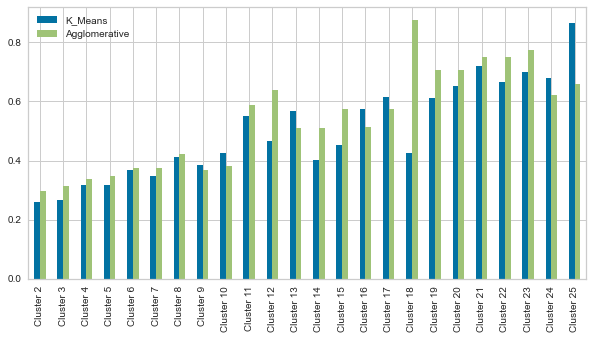

In [294]:
import matplotlib.pyplot as plt

df_New.plot.bar(figsize=(10,5))